# Watersheds Segmentation <a href="https://mybinder.org/v2/gh/InsightSoftwareConsortium/SimpleITK-Notebooks/master?filepath=Python%2F32_Watersheds_Segmentation.ipynb"><img style="float: right;" src="https://mybinder.org/badge_logo.svg"></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import SimpleITK as sitk
from myshow import myshow, myshow3d

# Download data to work on
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

Fetching cthead1.png


libpng warning: sCAL: invalid unit
libpng warning: sCAL: invalid unit
libpng warning: sCAL: invalid unit


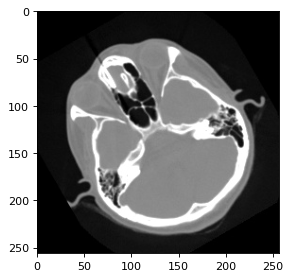

In [2]:
img = sitk.ReadImage(fdata("cthead1.png"))
myshow(img)

## Gradient Watersheds Segmentation

In [3]:
sigma = img.GetSpacing()[0]
level = 4

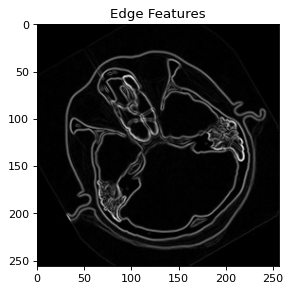

In [4]:
feature_img = sitk.GradientMagnitude(img)
myshow(feature_img, "Edge Features")

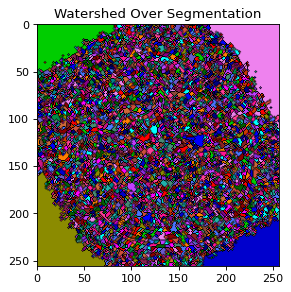

In [5]:
ws_img = sitk.MorphologicalWatershed(
    feature_img, level=0, markWatershedLine=True, fullyConnected=False
)
myshow(sitk.LabelToRGB(ws_img), "Watershed Over Segmentation")

In [6]:
from ipywidgets import interact, interactive, FloatSlider


def callback(feature_img, *args, **kwargs):
    ws_img = sitk.MorphologicalWatershed(feature_img, *args, **kwargs)

    myshow(sitk.LabelToRGB(ws_img), "Watershed Segmentation")


interact(
    lambda **kwargs: callback(feature_img, **kwargs),
    markWatershedLine=True,
    fullyConnected=False,
    level=FloatSlider(min=0, max=255, step=0.1, value=4.0),
)

interactive(children=(Checkbox(value=True, description='markWatershedLine'), Checkbox(value=False, description…

<function __main__.<lambda>(**kwargs)>

## Segmentation From Markers

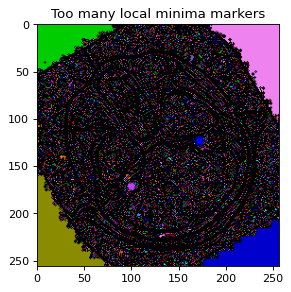

In [7]:
min_img = sitk.RegionalMinima(
    feature_img,
    backgroundValue=0,
    foregroundValue=1.0,
    fullyConnected=False,
    flatIsMinima=True,
)
marker_img = sitk.ConnectedComponent(min_img)
myshow(sitk.LabelToRGB(marker_img), "Too many local minima markers")

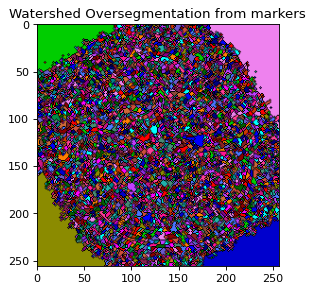

In [8]:
ws = sitk.MorphologicalWatershedFromMarkers(
    feature_img, marker_img, markWatershedLine=True, fullyConnected=False
)
myshow(sitk.LabelToRGB(ws), "Watershed Oversegmentation from markers")

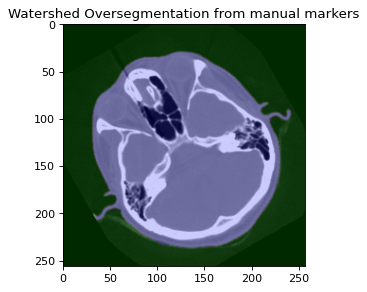

In [9]:
pt = [60, 60]
idx = img.TransformPhysicalPointToIndex(pt)
marker_img *= 0
marker_img[0, 0] = 1
marker_img[idx] = 2

ws = sitk.MorphologicalWatershedFromMarkers(
    feature_img, marker_img, markWatershedLine=True, fullyConnected=False
)
myshow(
    sitk.LabelOverlay(img, ws, opacity=0.2),
    "Watershed Oversegmentation from manual markers",
)

## Binary Watersheds for Object Separation 

Fetching coins.png


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


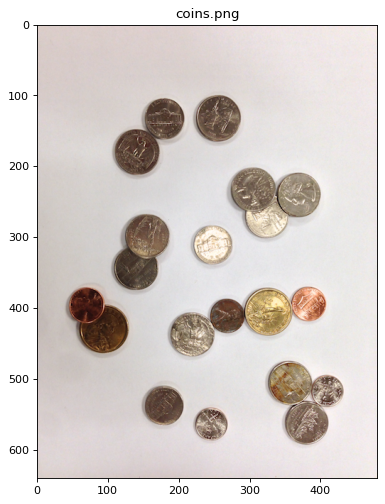

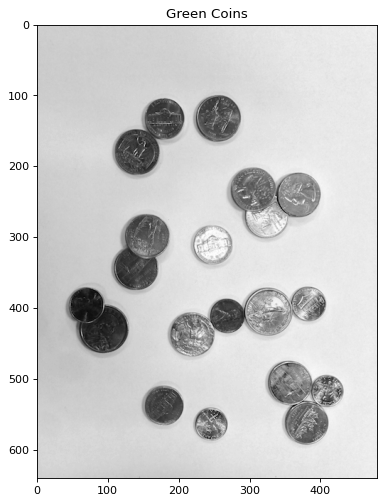

In [10]:
rgb_img = sitk.ReadImage(fdata("coins.png"))
myshow(rgb_img, "coins.png")
img = sitk.VectorIndexSelectionCast(rgb_img, 1)
myshow(img, "Green Coins")

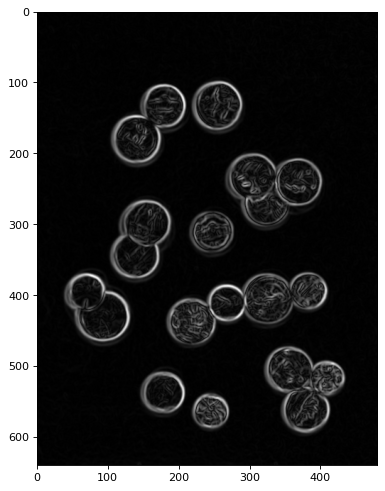

In [11]:
feature_img = sitk.GradientMagnitudeRecursiveGaussian(img, sigma=1.5)
myshow(feature_img)

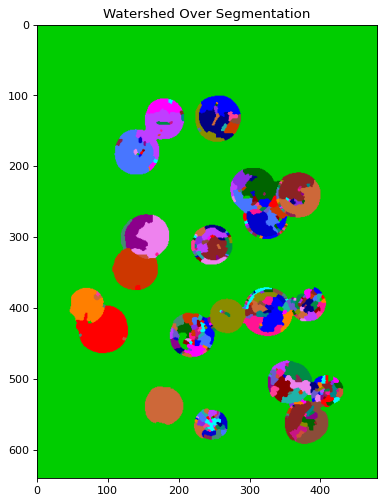

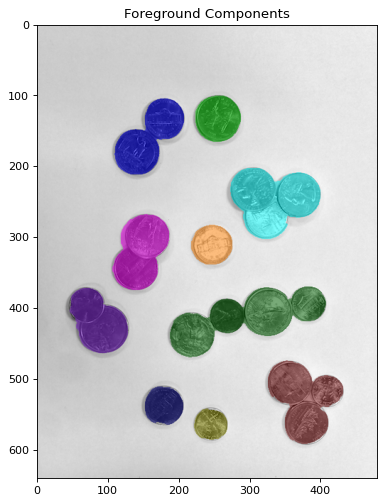

In [12]:
ws_img = sitk.MorphologicalWatershed(
    feature_img, level=4, markWatershedLine=False, fullyConnected=False
)
myshow(sitk.LabelToRGB(ws_img), "Watershed Over Segmentation")
seg = sitk.ConnectedComponent(ws_img != ws_img[0, 0])
myshow(sitk.LabelOverlay(img, seg), "Foreground Components")

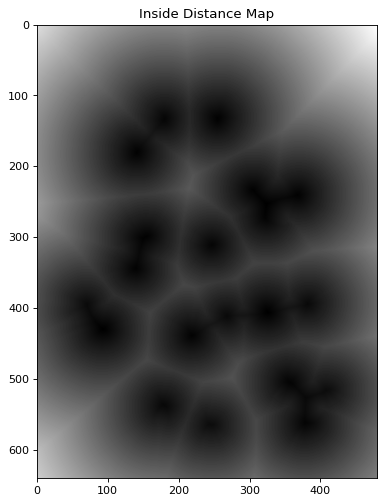

In [13]:
filled = sitk.BinaryFillhole(seg != 0)
d = sitk.SignedMaurerDistanceMap(
    filled, insideIsPositive=False, squaredDistance=False, useImageSpacing=False
)
myshow(d, "Inside Distance Map")

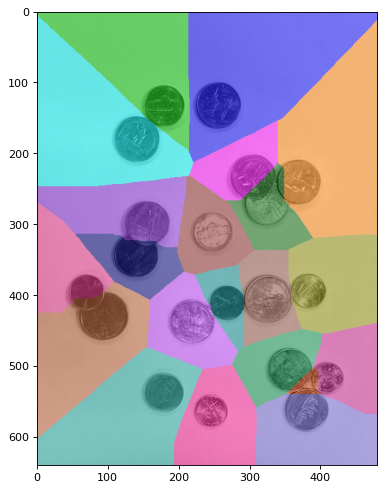

In [14]:
ws = sitk.MorphologicalWatershed(d, markWatershedLine=False, level=1)
myshow(sitk.LabelOverlay(img, ws))

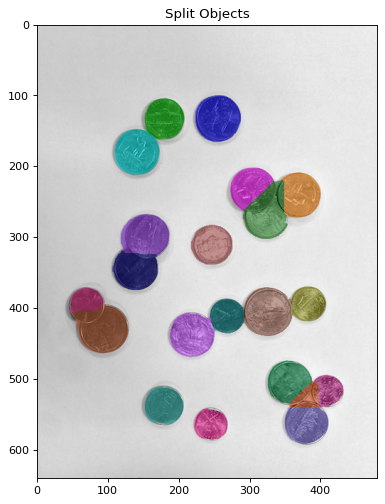

In [15]:
ws = sitk.Mask(ws, sitk.Cast(seg, ws.GetPixelID()))
myshow(sitk.LabelOverlay(img, ws), "Split Objects")

## Multi-label Morphology

In [16]:
seg = ws

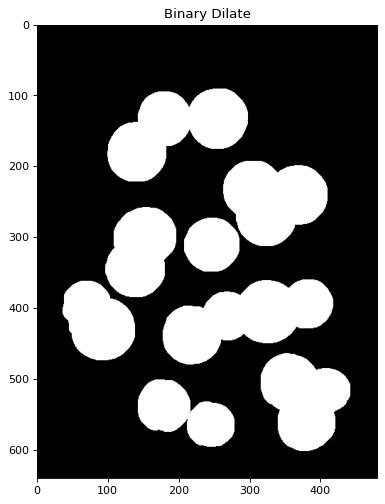

In [17]:
radius = 10
bd_img = sitk.BinaryDilate(seg != 0, [radius] * seg.GetDimension())
myshow(bd_img, "Binary Dilate")

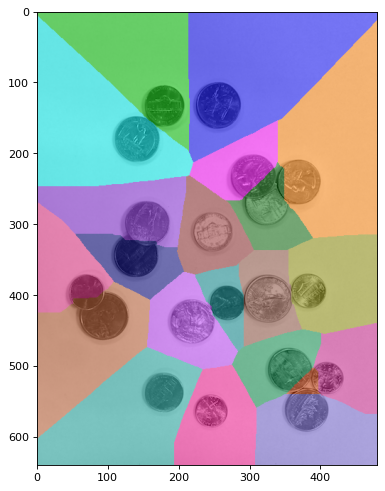

In [18]:
dist_img = sitk.SignedMaurerDistanceMap(
    seg != 0, insideIsPositive=False, squaredDistance=False, useImageSpacing=False
)
wsd_img = sitk.MorphologicalWatershedFromMarkers(dist_img, seg, markWatershedLine=False)
myshow(sitk.LabelOverlay(img, wsd_img))

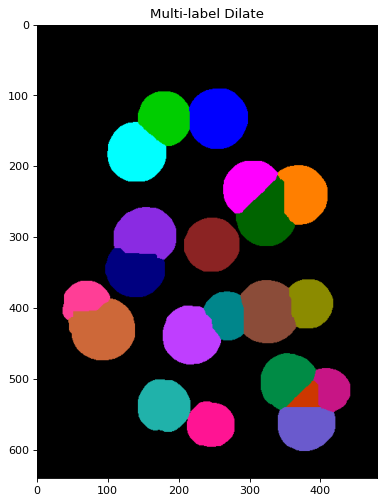

In [19]:
md_img = sitk.Mask(wsd_img, bd_img)
myshow(sitk.LabelToRGB(md_img), "Multi-label Dilate")

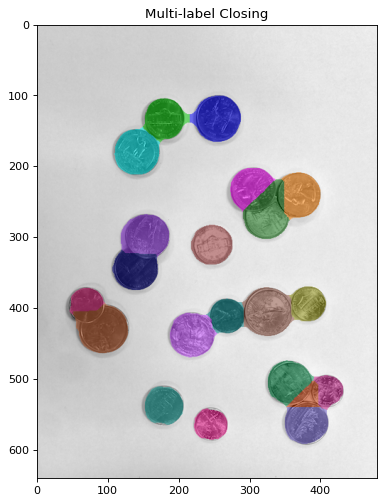

In [20]:
e_img = sitk.BinaryErode(md_img != 0, [radius] * md_img.GetDimension())
mo_img = sitk.Mask(md_img, e_img)
myshow(sitk.LabelOverlay(img, mo_img), "Multi-label Closing")